# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [0]:
import numpy as np
import os
import warnings
import cv2
warnings.filterwarnings('ignore')
from scipy.misc import imread, imresize
import datetime
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Input
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import *
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [0]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10#experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [0]:
IMG_SIZE = 200
CHANNELS = 3
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2))#create a list of image numbers you want to use for a particular video
    print(len(img_idx))
    orig_batch_size = batch_size
    while True:
        #print('still running')
        t = np.random.permutation(folder_list)
        batch_size = orig_batch_size
        if(len(folder_list)%batch_size)==0:
            num_batches = int(len(folder_list)/batch_size)# calculate the number of batches
        else:
            num_batches = int((len(folder_list)//batch_size) + 1)# calculate the number of batches
        #print('len(folder_list)',len(folder_list))
        #print('num_batches calculated',num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            #print('starting batch',batch,'of ',num_batches)
            if(batch==num_batches-1) and (len(folder_list)%batch_size)!=0:
                batch_size =  int(len(folder_list)%batch_size)
                print('for final batch, size is ',batch_size)
            batch_data = np.zeros((batch_size,len(img_idx),IMG_SIZE,IMG_SIZE,CHANNELS)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB            
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            #act_batch_data = np.zeros((batch_size,len(img_idx),100352))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print('img_idx',img_idx)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    #print('read image')
                    image = imresize(image, (IMG_SIZE, IMG_SIZE))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1]))/np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2]))/np.std(image[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
                #act_batch_data[folder] = model.predict(batch_data[folder])
            #print('yielding batch now')
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [0]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

We Start by building a CNN + RNN Model.<br/>
We use pre trained VGG16 layer and freeze its weights.<br/>
We follow it up with the GRU layer and finally finish it up with a final Softmax activation layer.

In [0]:
#write your model here
TIMESTEPS = 15
inputs = Input(shape=(TIMESTEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='timeDistributedVgg16')(inputs)
output_2 = TimeDistributed(Flatten())(output_1)
output_3 = GRU(500,return_sequences=False)(output_2)
predictions = Dense(5, activation='softmax')(output_3)

pred_model = Model([inputs],predictions)
pred_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 18432)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 500)               28399500  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2505      
Total params: 43,116,693
Trainable params: 43,116,693
Non-trainable params: 0
_________________________________________________________________


In [0]:
for layer in pred_model.layers:
    if layer.name == 'timeDistributedVgg16':
        layer.trainable = False

In [0]:
pred_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 18432)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 500)               28399500  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2505      
Total params: 43,116,693
Trainable params: 28,402,005
Non-trainable params: 14,714,688
_________________________________________________________________


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [0]:
optimiser = keras.optimizers.Adam()#write your optimizer
pred_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [0]:
model_name = 'model1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:
print('num_train_sequences',len(train_doc))
print('num_val_sequences',len(val_doc))
print('batch size',batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print('steps_per_epoch',steps_per_epoch)
print('validation_steps',validation_steps)

num_train_sequences 663
num_val_sequences 100
batch size 10
steps_per_epoch 67
validation_steps 10


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [0]:
pred_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1)

Source path =  Project_data/val Source path =  ; batch size = 10
15
Epoch 1/10
Project_data/train ; batch size = 10
15
for final batch, size is  3

Epoch 00001: val_loss improved from inf to 1.30120, saving model to model1_init_2020-02-0307_31_47.605115/model-00001-3.20904-0.38009-1.30120-0.44000.h5
Epoch 2/10
for final batch, size is  3

Epoch 00002: val_loss improved from 1.30120 to 0.98991, saving model to model1_init_2020-02-0307_31_47.605115/model-00002-0.98061-0.68778-0.98991-0.62000.h5
Epoch 3/10
for final batch, size is  3

Epoch 00003: val_loss improved from 0.98991 to 0.79086, saving model to model1_init_2020-02-0307_31_47.605115/model-00003-0.58952-0.86727-0.79086-0.74000.h5
Epoch 4/10
for final batch, size is  3

Epoch 00004: val_loss improved from 0.79086 to 0.67344, saving model to model1_init_2020-02-0307_31_47.605115/model-00004-0.30361-0.96229-0.67344-0.77000.h5
Epoch 5/10
for final batch, size is  3

Epoch 00005: val_loss improved from 0.67344 to 0.55826, saving model

In [0]:
import matplotlib.pyplot as plt

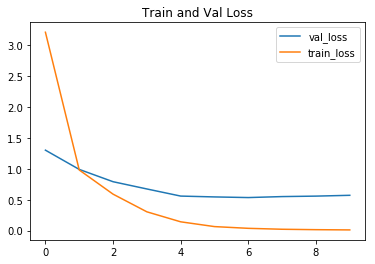

In [0]:
plt.figure()
plt.title('Train and Val Loss')
plt.plot(range(0,10),pred_model.history.history['val_loss'],label='val_loss')
plt.plot(range(0,10),pred_model.history.history['loss'],label='train_loss')
plt.legend()
plt.show()

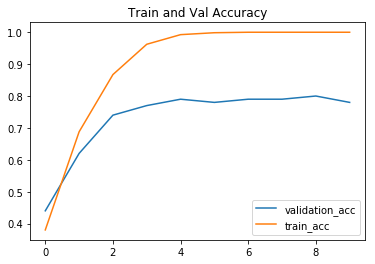

In [0]:
plt.figure()
plt.title('Train and Val Accuracy')
plt.plot(range(0,10),pred_model.history.history['val_categorical_accuracy'],label='validation_acc')
plt.plot(range(0,10),pred_model.history.history['categorical_accuracy'],label='train_acc')
plt.legend()
plt.show()

Try with Dropout, fewer GRU dimensions and Batch Normalization to see if Validation accuracy improves

In [0]:
#write your model here
TIMESTEPS = 15
inputs = Input(shape=(TIMESTEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='timeDistributedVgg16')(inputs)
output_2 = TimeDistributed(keras.layers.Dropout(0.9))(output_1)
output_3 = TimeDistributed(keras.layers.BatchNormalization())(output_2)
output_4 = TimeDistributed(Flatten())(output_3)
output_5 = GRU(300,return_sequences=False)(output_4)
predictions = Dense(5, activation='softmax')(output_5)

pred_model_2 = Model([inputs],predictions)
pred_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 6, 6, 512)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 6, 6, 512)     2048      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 18432)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 300)               16859700  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1505      
Total para

In [0]:
for layer in pred_model_2.layers:
    if layer.name == 'timeDistributedVgg16':
        layer.trainable = False

In [0]:
pred_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 6, 6, 512)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 15, 6, 6, 512)     2048      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 18432)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 300)               16859700  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1505      
Total para

In [0]:
optimiser = keras.optimizers.Adam()#write your optimizer
pred_model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_name = 'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2)

callbacks_list = [checkpoint, LR]

In [0]:
pred_model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None)

Epoch 1/10
for final batch, size is  3

Epoch 00001: val_loss improved from inf to 0.73091, saving model to model2_init_2020-02-0515_38_04.829051/model-00001-1.18345-0.57919-0.73091-0.73000.h5
Epoch 2/10
for final batch, size is  3

Epoch 00002: val_loss improved from 0.73091 to 0.53389, saving model to model2_init_2020-02-0515_38_04.829051/model-00002-0.27966-0.90649-0.53389-0.78000.h5
Epoch 3/10
for final batch, size is  3

Epoch 00003: val_loss improved from 0.53389 to 0.39852, saving model to model2_init_2020-02-0515_38_04.829051/model-00003-0.10013-0.97285-0.39852-0.84000.h5
Epoch 4/10
for final batch, size is  3

Epoch 00004: val_loss did not improve from 0.39852
Epoch 5/10
for final batch, size is  3

Epoch 00005: val_loss did not improve from 0.39852
Epoch 6/10
for final batch, size is  3

Epoch 00006: val_loss did not improve from 0.39852
Epoch 7/10
for final batch, size is  3

Epoch 00007: val_loss improved from 0.39852 to 0.19792, saving model to model2_init_2020-02-0515_38_

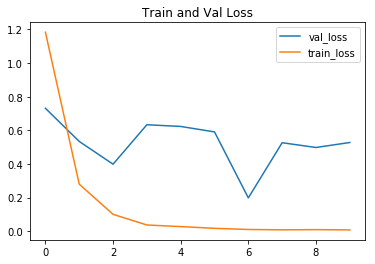

In [0]:
plt.figure()
plt.title('Train and Val Loss')
plt.plot(range(0,10),pred_model_2.history.history['val_loss'],label='val_loss')
plt.plot(range(0,10),pred_model_2.history.history['loss'],label='train_loss')
plt.legend()
plt.show()

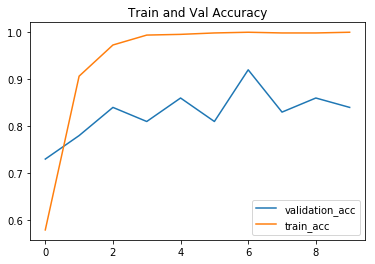

In [0]:
plt.figure()
plt.title('Train and Val Accuracy')
plt.plot(range(0,10),pred_model_2.history.history['val_categorical_accuracy'],label='validation_acc')
plt.plot(range(0,10),pred_model_2.history.history['categorical_accuracy'],label='train_acc')
plt.legend()
plt.show()

#### The best Model achieved a validation accuracy of 92% as shown in the results above.

Try with batch normalization and dropout after every layer.

In [0]:
#write your model here
TIMESTEPS = 15
inputs = Input(shape=(TIMESTEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
#input_1 = keras.layers.Dropout(0.2)(inputs)
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='timeDistributedVgg16')(inputs)
output_2 = TimeDistributed(keras.layers.Dropout(0.8))(output_1)
output_3 = TimeDistributed(keras.layers.BatchNormalization())(output_2)
output_4 = TimeDistributed(Flatten())(output_3)
output_5 = GRU(100,return_sequences=False)(output_4)
output_6 = keras.layers.Dropout(0.8)(output_5)
output_7 = keras.layers.BatchNormalization()(output_6)
predictions = Dense(5, activation='softmax')(output_7)

pred_model_3 = Model([inputs],predictions)
pred_model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 6, 6, 512)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 6, 6, 512)     2048      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 18432)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               5559900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

In [0]:
for layer in pred_model_3.layers:
    if layer.name == 'timeDistributedVgg16':
        layer.trainable = False

In [0]:
pred_model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 6, 6, 512)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 6, 6, 512)     2048      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 18432)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               5559900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

In [0]:
optimiser = keras.optimizers.RMSprop()#write your optimizer
pred_model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_name = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2)

callbacks_list = [checkpoint, LR]

In [0]:
pred_model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None)

Epoch 1/10
for final batch, size is  3

Epoch 00001: val_loss did not improve from 0.50086
Epoch 2/10
for final batch, size is  3

Epoch 00002: val_loss did not improve from 0.50086
Epoch 3/10
for final batch, size is  3

Epoch 00003: val_loss did not improve from 0.50086
Epoch 4/10
for final batch, size is  3

Epoch 00004: val_loss did not improve from 0.50086
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.50086
Epoch 6/10
for final batch, size is  3

Epoch 00006: val_loss did not improve from 0.50086
Epoch 7/10
for final batch, size is  3

Epoch 00007: val_loss did not improve from 0.50086
Epoch 8/10
for final batch, size is  3

Epoch 00008: val_loss did not improve from 0.50086
Epoch 9/10
for final batch, size is  3

Epoch 00010: val_loss did not improve from 0.50086


We will load the best Model and evaluate the result on validation set.<br/>
The best model had achieved 81% accuracy on both Train and Validation sets

In [0]:
pred_model_3.load_weights('model3_init_2020-02-0309_40_46.191674/model-00010-0.48434-0.81448-0.50561-0.81000.h5')

In [0]:
pred_model_3.evaluate_generator(val_generator,validation_steps)

[0.5056131049990654, 0.8099999904632569]

In [0]:
pred_model_3.metrics_names

['loss', 'categorical_accuracy']

We will try a bidirectional GRU layer

In [0]:
#write your model here
TIMESTEPS = 15
inputs = Input(shape=(TIMESTEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
#input_1 = keras.layers.Dropout(0.2)(inputs)
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='timeDistributedVgg16')(inputs)
output_2 = TimeDistributed(keras.layers.Dropout(0.8))(output_1)
output_3 = TimeDistributed(keras.layers.BatchNormalization())(output_2)
output_4 = TimeDistributed(Flatten())(output_3)
output_5 = keras.layers.Bidirectional(GRU(100,return_sequences=False))(output_4)
output_6 = keras.layers.Dropout(0.8)(output_5)
output_7 = keras.layers.BatchNormalization()(output_6)
predictions = Dense(5, activation='softmax')(output_7)

pred_model_4 = Model([inputs],predictions)
pred_model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 6, 6, 512)     0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 6, 6, 512)     2048      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 18432)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               11119800  
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
__________

In [0]:
for layer in pred_model_4.layers:
    if layer.name == 'timeDistributedVgg16':
        layer.trainable = False

In [0]:
pred_model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 15, 200, 200, 3)   0         
_________________________________________________________________
timeDistributedVgg16 (TimeDi (None, 15, 6, 6, 512)     14714688  
_________________________________________________________________
time_distributed_10 (TimeDis (None, 15, 6, 6, 512)     0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 15, 6, 6, 512)     2048      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 18432)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               11119800  
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
__________

In [0]:
optimiser = keras.optimizers.RMSprop()#write your optimizer
pred_model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model_name = 'model4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2)

callbacks_list = [checkpoint, LR]

In [0]:
pred_model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None)

Epoch 1/10
for final batch, size is  3

Epoch 00001: val_loss improved from 0.54514 to 0.54233, saving model to model4_init_2020-02-0415_41_15.347086/model-00001-0.43126-0.84314-0.54233-0.81000.h5
Epoch 2/10
for final batch, size is  3

Epoch 00002: val_loss did not improve from 0.54233
Epoch 3/10
for final batch, size is  3

Epoch 00003: val_loss did not improve from 0.54233
Epoch 4/10
for final batch, size is  3

Epoch 00004: val_loss did not improve from 0.54233
Epoch 5/10
for final batch, size is  3

Epoch 00005: val_loss did not improve from 0.54233
Epoch 6/10
for final batch, size is  3

Epoch 00006: val_loss did not improve from 0.54233
Epoch 7/10
for final batch, size is  3

Epoch 00007: val_loss improved from 0.54233 to 0.53983, saving model to model4_init_2020-02-0415_41_15.347086/model-00007-0.41714-0.84917-0.53983-0.81000.h5
Epoch 8/10
for final batch, size is  3

Epoch 00008: val_loss did not improve from 0.53983
Epoch 9/10
for final batch, size is  3

Epoch 00009: val_los

We did not Notice any improvement in the validation accuracy with Bidirectional GRU. Next we are going to use CONV-3D models to see if we perofrm better with fewer parameters.

First we wil import all required libraries.

In [0]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Dropout, TimeDistributed, Flatten, BatchNormalization, Activation, Input
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import *
import matplotlib.pyplot as plt

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [0]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc) #change training data size for initial phase
num_val_sequences = len(val_doc) #val training data can be kept as such
num_epochs = 30 # choose the number of epochs
batch_size = 100 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [0]:
IMG_SIZE = 120
CHANNELS = 3
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #note using alternate 15 images here
    img_idx = list(range(0,30,2))#create a list of image numbers you want to use for a particular video
    #img_idx = list(range(5, 25)) #taking middle frames only
    orig_batch_size = batch_size
    while True:
        
        t = np.random.permutation(folder_list)
        batch_size = orig_batch_size
        if(len(folder_list)%batch_size)==0:
            num_batches = int(len(folder_list)/batch_size)# calculate the number of batches
        else:
            num_batches = int((len(folder_list)//batch_size) + 1)# calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            if(batch==num_batches-1) and (len(folder_list)%batch_size)!=0:
                batch_size =  int(len(folder_list)%batch_size)
                #print('for final batch, size is ',batch_size)
                
            batch_data = np.zeros((batch_size,len(img_idx),IMG_SIZE,IMG_SIZE,CHANNELS)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB            
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            #act_batch_data = np.zeros((batch_size,len(img_idx),100352))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print('img_idx',img_idx)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    #print('read image')
                    image = imresize(image, (IMG_SIZE, IMG_SIZE))
                    #(image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1]))/np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2]))/np.std(image[:,:,2])
                    #(image[:,:,2] - np.percentile(image[:,:,2], 5))/(np.percentile(image[:,:,2], 95) - np.percentile(image[:,:,2], 5))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [0]:
def CNN3D():
    model = Sequential()

    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation = 'relu', input_shape = (15, 120, 120, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, kernel_size = (3, 3, 3), activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1,2,2)))

    model.add(Conv3D(64, kernel_size = (3, 3, 3), activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, kernel_size = (3, 3, 3), activation = 'relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(5, activation = 'softmax'))
    return model
    return model

In [0]:
def VGG16_CNN3D():
    TIMESTEPS = 15
    inputs = Input(shape=(TIMESTEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
    #input_1 = keras.layers.Dropout(0.2)(inputs)
    output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='timeDistributedVgg16')(inputs)
    output_2 = TimeDistributed(keras.layers.Dropout(0.8))(output_1)
    output_3 = TimeDistributed(keras.layers.BatchNormalization())(output_2)

    output_5 = Conv3D(64,kernel_size = (3, 3, 3), activation = 'relu', padding='same')(output_3)
    output_6 = keras.layers.BatchNormalization()(output_5)
    output_7 = MaxPooling3D(pool_size=(2, 2, 2))(output_6)

    output_8 = Flatten()(output_7)
    output_9 = Dense(256, activation='relu')(output_8)
    output_10 = keras.layers.Dropout(0.5)(output_9)
    output_11 = Dense(128, activation='relu')(output_10)
    output_12 = keras.layers.Dropout(0.5)(output_11)
    predictions = Dense(5, activation = 'softmax')(output_12)

    model = Model([inputs],predictions)
    
    #freezing the vgg16 layers
    for layer in model.layers:
        if layer.name == 'timeDistributedVgg16':
            layer.trainable = False
        
    return model

In [0]:
def model_generator(modeltype):
    if modeltype == 1:
        return CNN3D()
    if modeltype == 2:
        return Pretrained_CNN3D()

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

#### Callbacks

In [0]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=True, mode='auto', period=1)

#pateince = after how many epochs the learning rate should be reduced.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4 , cooldown=1, verbose=1)
callbacks_list = [LR, checkpoint]

#### Steps per Epoch, Validation steps

In [0]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [0]:
print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)
print('# batch size = ', batch_size)
print('steps per epoch = ' , steps_per_epoch)
print('validation steps = ', validation_steps)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch size =  100
steps per epoch =  7
validation steps =  1


In [0]:
#1 for CNN3D
#2 for VGG16_CNN3D
model = model_generator(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 15, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 60, 32)     13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 60, 60, 32)     128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 30, 30, 64)     55360     
__________

#### Optimisers

In [0]:
#optimiser = optimizers.SGD(lr=0.001, momentum=0.9)#write your optimizer
#SGD(lr=0.0001, momentum = 0.9)#SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

#### Generators

In [0]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#### Model summary

In [0]:
model.summary()

#### Fit generators

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [0]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 100
Source path =  Project_data/train Epoch 1/30; batch size = 100

7/7 [==============================] - 106s 15s/step - loss: 4.3290 - categorical_accuracy: 0.2340 - val_loss: 1.7024 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-02-1013_33_48.342472/model-00001-4.46020-0.23077-1.70237-0.24000.h5
Epoch 2/30
7/7 [==============================] - 41s 6s/step - loss: 1.5521 - categorical_accuracy: 0.3673 - val_loss: 1.4880 - val_categorical_accuracy: 0.3100

Epoch 00002: saving model to model_init_2020-02-1013_33_48.342472/model-00002-1.55887-0.36199-1.48802-0.31000.h5
Epoch 3/30
7/7 [==============================] - 38s 5s/step - loss: 1.4412 - categorical_accuracy: 0.3535 - val_loss: 1.4619 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_init_2020-02-1013_33_48.342472/model-00003-1.44048-0.35294-1.46189-0.28000.h5
Epoch 4/30
7/7 [==============================] - 38s 5s/step - lo

The Best CONV3D model achieved 81% Accuracy on the validation Set with 1 million parameters.
This we will use as final model as it has manageable size of parameters.